#  Multivariate Gaussian Test
Comparison of MCMC and PLC in a multi-variate gaussian problem

This tutorial produces an N-dimensional multivariate Gaussian
with a non-trivial covariance matrix.  By default N=4 (called "dim").

A subset of these are considered parameters of interest.
This problem is tractable analytically.

We use this mainly as a test of Markov Chain Monte Carlo
and we compare the result to the profile likelihood ratio.

We use the proposal helper to create a customized
proposal function for this problem.

For N=4 and 2 parameters of interest it takes about 10-20 seconds
and the acceptance rate is 37%




**Author:**  Kevin Belasco and Kyle Cranmer  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 03:12 AM.</small></i>

In [1]:
%%cpp -d
#include "RooGlobalFunc.h"
#include <stdlib.h>
#include "TMatrixDSym.h"
#include "RooMultiVarGaussian.h"
#include "RooArgList.h"
#include "RooRealVar.h"
#include "TH2F.h"
#include "TCanvas.h"
#include "RooAbsReal.h"
#include "RooFitResult.h"
#include "TStopwatch.h"
#include "RooStats/MCMCCalculator.h"
#include "RooStats/MetropolisHastings.h"
#include "RooStats/MarkovChain.h"
#include "RooStats/ConfInterval.h"
#include "RooStats/MCMCInterval.h"
#include "RooStats/MCMCIntervalPlot.h"
#include "RooStats/ModelConfig.h"
#include "RooStats/ProposalHelper.h"
#include "RooStats/ProposalFunction.h"
#include "RooStats/PdfProposal.h"
#include "RooStats/ProfileLikelihoodCalculator.h"
#include "RooStats/LikelihoodIntervalPlot.h"
#include "RooStats/LikelihoodInterval.h"

using namespace std;

In [2]:
%%cpp -d
// This is a workaround to make sure the namespace is used inside functions
using namespace RooFit;
using namespace RooStats;

 Arguments are defined. 

In [3]:
Int_t dim = 4;
Int_t nPOI = 2;

Let's time this challenging example

In [4]:
TStopwatch t;
t.Start();

RooArgList xVec;
RooArgList muVec;
RooArgSet poi;


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Make the observable and means

In [5]:
Int_t i, j;
RooRealVar *x;
RooRealVar *mu_x;
for (i = 0; i < dim; i++) {
   char *name = Form("x%d", i);
   x = new RooRealVar(name, name, 0, -3, 3);
   xVec.add(*x);

   char *mu_name = Form("mu_x%d", i);
   mu_x = new RooRealVar(mu_name, mu_name, 0, -2, 2);
   muVec.add(*mu_x);
}

Put them into the list of parameters of interest

In [6]:
for (i = 0; i < nPOI; i++) {
   poi.add(*muVec.at(i));
}

Make a covariance matrix that is all 1's

In [7]:
TMatrixDSym cov(dim);
for (i = 0; i < dim; i++) {
   for (j = 0; j < dim; j++) {
      if (i == j)
         cov(i, j) = 3.;
      else
         cov(i, j) = 1.0;
   }
}

Now make the multivariate gaussian

In [8]:
RooMultiVarGaussian mvg("mvg", "mvg", xVec, muVec, cov);

--------------------
 make a toy dataset

In [9]:
RooDataSet *data = mvg.generate(xVec, 100);

Now create the model config for this problem

In [10]:
RooWorkspace *w = new RooWorkspace("MVG");
ModelConfig modelConfig(w);
modelConfig.SetPdf(mvg);
modelConfig.SetParametersOfInterest(poi);

-------------------------------------------------------
 Setup calculators

Mcmc
 we want to setup an efficient proposal function
 using the covariance matrix from a fit to the data

In [11]:
RooFitResult *fit = mvg.fitTo(*data, Save(true));
ProposalHelper ph;
ph.SetVariables((RooArgSet &)fit->floatParsFinal());
ph.SetCovMatrix(fit->covarianceMatrix());
ph.SetUpdateProposalParameters(true);
ph.SetCacheSize(100);
ProposalFunction *pdfProp = ph.GetProposalFunction();

[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 mu_x0        0.00000e+00  4.00000e-01   -2.00000e+00  2.00000e+00
     2 mu_x1        0.00000e+00  4.00000e-01   -2.00000e+00  2.00000e+00
     3 mu_x2        0.00000e+00  4.00000e-01   -2.00000e+00  2.00000e+00
     4 mu_x3        0.00000e+00  4.00000e-01   -2.00000e+00  2.00000e+00
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        2000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FC

Now create the calculator

In [12]:
MCMCCalculator mc(*data, modelConfig);
mc.SetConfidenceLevel(0.95);
mc.SetNumBurnInSteps(100);
mc.SetNumIters(10000);
mc.SetNumBins(50);
mc.SetProposalFunction(*pdfProp);

MCMCInterval *mcInt = mc.GetInterval();
RooArgList *poiList = mcInt->GetAxes();

[#1] INFO:Minization -- createNLL: caching constraint set under name CONSTR_OF_PDF_mvg_FOR_OBS_x0:x1:x2:x3 with 0 entries
Metropolis-Hastings progress: ....................................................................................................
[#1] INFO:Eval -- Proposal acceptance rate: 37.1%
[#1] INFO:Eval -- Number of steps in chain: 3710


Now setup the profile likelihood calculator

In [13]:
ProfileLikelihoodCalculator plc(*data, modelConfig);
plc.SetConfidenceLevel(0.95);
LikelihoodInterval *plInt = (LikelihoodInterval *)plc.GetInterval();

[#1] INFO:Minization -- createNLL picked up cached consraints from workspace with 0 entries
[#0] PROGRESS:Minization -- ProfileLikelihoodCalcultor::DoGLobalFit - find MLE 
[#0] PROGRESS:Minization -- ProfileLikelihoodCalcultor::DoMinimizeNLL - using Minuit / Migrad with strategy 1
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization -- 
  RooFitResult: minimized FCN value: 706.56, estimated distance to minimum: 1.16082e-08
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                 mu_x0    1.8119e-01 +/-  1.73e-01
                 mu_x1    2.0792e-01 +/-  1.73e-01
                 mu_x2   -1.6078e-02 +/-  1.73e-01
                 mu_x3    1.2370e-01 +/-  1.73e-01



Make some plots

In [14]:
MCMCIntervalPlot mcPlot(*mcInt);

TCanvas *c1 = new TCanvas();
mcPlot.SetLineColor(kGreen);
mcPlot.SetLineWidth(2);
mcPlot.Draw();

LikelihoodIntervalPlot plPlot(plInt);
plPlot.Draw("same");

if (poiList->getSize() == 1) {
   RooRealVar *p = (RooRealVar *)poiList->at(0);
   Double_t ll = mcInt->LowerLimit(*p);
   Double_t ul = mcInt->UpperLimit(*p);
   cout << "MCMC interval: [" << ll << ", " << ul << "]" << endl;
}

if (poiList->getSize() == 2) {
   RooRealVar *p0 = (RooRealVar *)poiList->at(0);
   RooRealVar *p1 = (RooRealVar *)poiList->at(1);
   TCanvas *scatter = new TCanvas();
   Double_t ll = mcInt->LowerLimit(*p0);
   Double_t ul = mcInt->UpperLimit(*p0);
   cout << "MCMC interval on p0: [" << ll << ", " << ul << "]" << endl;
   ll = mcInt->LowerLimit(*p0);
   ul = mcInt->UpperLimit(*p0);
   cout << "MCMC interval on p1: [" << ll << ", " << ul << "]" << endl;

   // MCMC interval on p0: [-0.2, 0.6]
   // MCMC interval on p1: [-0.2, 0.6]

   mcPlot.DrawChainScatter(*p0, *p1);
   scatter->Update();
}

t.Print();

[#1] INFO:Minization -- RooProfileLL::evaluate(nll_mvg_mvgData_Profile[mu_x0,mu_x1]) Creating instance of MINUIT
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_mvg_mvgData_Profile[mu_x0,mu_x1]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_mvg_mvgData_Profile[mu_x0,mu_x1]) minimum found at (mu_x0=0.181184, mu_x1=0.207917)
..[#1] INFO:Minization -- LikelihoodInterval - Finding the contour of mu_x0 ( 0 ) and mu_x1 ( 1 ) 
MCMC interval on p0: [-0.28, 0.6]
MCMC interval on p1: [-0.28, 0.6]
Real time 0:00:02, CP time 1.910


Draw all canvases 

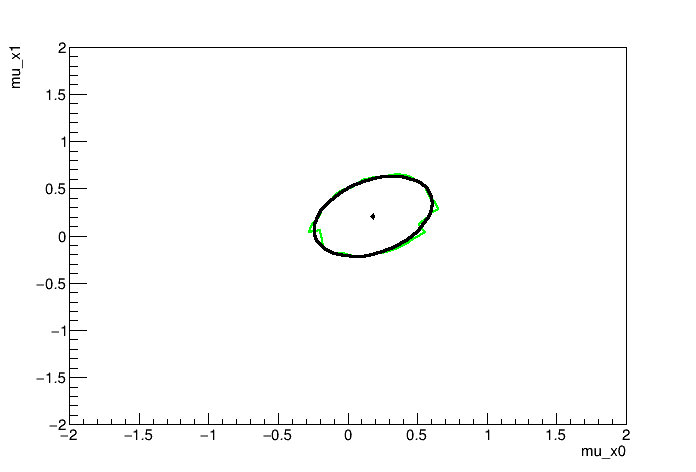

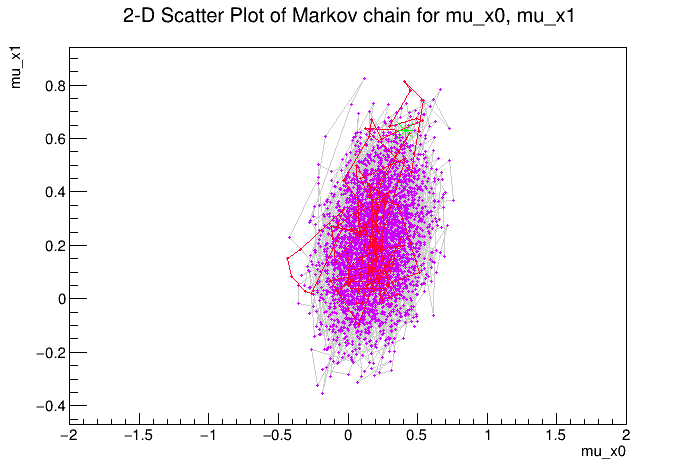

In [15]:
gROOT->GetListOfCanvases()->Draw()